# LR-FHSS balloon dataset: filtering and visualization

This notebook is used to filter the [balloon experiment dataset](../dataset/dataset.json), and visualize the extracted data.
The produced figures are used in a [presentation](https://hal.science/hal-04777306) at the [2024 LPWAN days](https://cpham.perso.univ-pau.fr/LPWAN24/) seminar, and in a collaborative paper summited to [ICC'25](https://icc2025.ieee-icc.org/).


### Authors
- Florent Dobler (Université Genoble Alpes LIG)



Import the modules used throughout the notebook and some global configuration

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import EngFormatter
import numpy as np
import json
import datetime
import pandas as pd
from pyproj import Geod
import os
from irma_nacelle_position_parser import getAltitude,getLatitude,getLongitude


matplotlib.rcParams.update({'font.size': 14})

The dataset is at `../dataset/dataset.json` 

The first step is to filter the dataset. We are filtering out:
- Frames where the tx power is over 14 dBm
- Frames sent when the GPS postions bugged out
- Frames sent when the ballons where on the ground

We then save that new filtered dataset as `../dataset/dataset_filtered.json`


In [15]:
# Filter and cleanup the dataset
MAX_COUNT_THRESHOLD = 10

df = pd.read_json("../dataset/dataset.json")

# Duration of the experiment
df_sorted_timestamp = df.sort_values(by = ["rx_timestamp_ms"])
experiment_start_timestamp,experiment_end_timestamp  = df_sorted_timestamp["rx_timestamp_ms"].iloc[0],df_sorted_timestamp["rx_timestamp_ms"].iloc[-1]
print(f"Total experiment time: {(experiment_end_timestamp - experiment_start_timestamp)//3600000} hours and {int(((experiment_end_timestamp - experiment_start_timestamp)/3600000 - ((experiment_end_timestamp - experiment_start_timestamp)//3600000))*60)} minutes ")

print(f"Initial frame number:\t{len(df.index)}")

# Remove the frames where the power is over 14 dbm 
df = df[df["tx_power_dbm"]<= 14]

# Compute the estimated latitude, longitude and altitude.
df["estimated_lat_lon_alt"] = df[["rx_timestamp_ms","balloon_id"]].apply(lambda row: [
    float(getLatitude(row["rx_timestamp_ms"],row["balloon_id"] - 1)),
    float(getLongitude(row["rx_timestamp_ms"],row["balloon_id"] - 1)),
    float(getAltitude(row["rx_timestamp_ms"],row["balloon_id"] - 1))
],axis=1)

# Aggeragte the GPS positions
df["aggregated_gps"] = df["estimated_lat_lon_alt"].apply(lambda x: f"{x[0]}:{x[1]}:{x[2]}")

# Count occurrences of each unique "aggregated_gps"
gps_counts = df['aggregated_gps'].value_counts()

# Filter the DataFrame to keep only rows with counts less than or equal to the threshold
df = df[df['aggregated_gps'].map(gps_counts) <= MAX_COUNT_THRESHOLD]

# Filter the points to only keep the ones where the altitude is above x meters
df = df[df["estimated_lat_lon_alt"].apply(lambda x: x[2]>= 300)]

print(f"Filtered frame number:\t{len(df.index)}")


# Export the dataset as a json again
df.to_json("../dataset/dataset_filtered.json",indent=4,orient='records')


Total experiment time: 2 hours and 28 minutes 
Initial frame number:	2033
Filtered frame number:	1377


Compute the flight time of the three NCU

In [16]:
df = pd.read_json("../dataset/dataset_filtered.json")

# There is no need to filter out the altitude of the balloon, since the dataset is already filtered. 
for nacelle_number in sorted(df["balloon_id"].unique()):
    df_ncu = df[df["balloon_id"] == nacelle_number]
    df_ncu = df_ncu.sort_values(by = ["rx_timestamp_ms"])
    flight_time_ms = df_ncu["rx_timestamp_ms"].iloc[-1] -  df_ncu["rx_timestamp_ms"].iloc[0]
    print(f"NCU{nacelle_number} flew for {flight_time_ms/1000}\ts")


NCU1 flew for 7200.323	s
NCU2 flew for 6652.56	s
NCU3 flew for 6891.777	s


We want to plot the altitude of the balloons when a frame was received, to gauge wether the balloon ascending or desending has any impact on the transmission.  

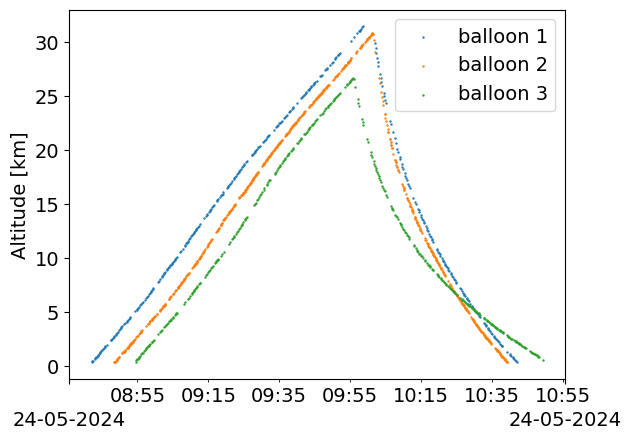

In [17]:
# Load the data
dataFile = open("../dataset/dataset_filtered.json","r")
# dataFile = open("output/all_data.json","r")
data = json.loads(dataFile.read())
dataFile.close()

dataPoints = [[packet["rx_timestamp_ms"],packet["estimated_lat_lon_alt"][2],packet["balloon_id"],packet["dev_addr"]] for packet in data]

# No altitude filtering
# group the data by nacelle
timestamp,altitude,nacelleNumbers,dev_addr = np.transpose(dataPoints)
nacelleIds = [int(nacelleNumber) - 1 for nacelleNumber in np.unique(nacelleNumbers)]

altitudes = [[] for _ in range(len(nacelleIds))]
timestamps = [[] for _ in range(len(nacelleIds))]

for dataPoint in dataPoints:
    nacelleId = dataPoint[2] - 1
    altitudes[nacelleId].append(dataPoint[1])
    timestamps[nacelleId].append(dataPoint[0])


fig,ax = plt.subplots()
# fig.suptitle("Altitude of the balloons when a packet was received")
for nacelleId in nacelleIds:
    timestamp = timestamps[nacelleId]
    
    timestamp = [datetime.datetime.fromtimestamp(time/1000,datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo) for time in timestamp]
    altitude = [alt/1000 for alt in altitudes[nacelleId]]



    ax.xaxis.set_minor_locator(dates.MinuteLocator(interval=20))   # every 20 minutes
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
    ax.xaxis.set_major_locator(dates.DayLocator(interval=1))    # every day
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n%d-%m-%Y'))

    ax.set_ylabel("Altitude [km]")
    format = EngFormatter(unit="km")
    ax.yaxis.set_minor_formatter(format)


    ax.scatter(timestamp,altitude,label=f"balloon {nacelleId +1}",s=0.5)
    # scale = 0.7
    # fig.set_size_inches((16*scale,9*scale))


ax.legend()
os.makedirs("../dataset/output",exist_ok=True)
plt.savefig("../dataset/output/balloon_altitude_when_frame_received.pdf",dpi=1000)
plt.show()


We want to disply the RSSI as a function of the distance between the ballons and the gateway

The gatway was [there](https://maps.app.goo.gl/9bUDD5s7DkW1xR248)

`gateway position : 43.706172, -0.251466 , ~ 5 (m)`

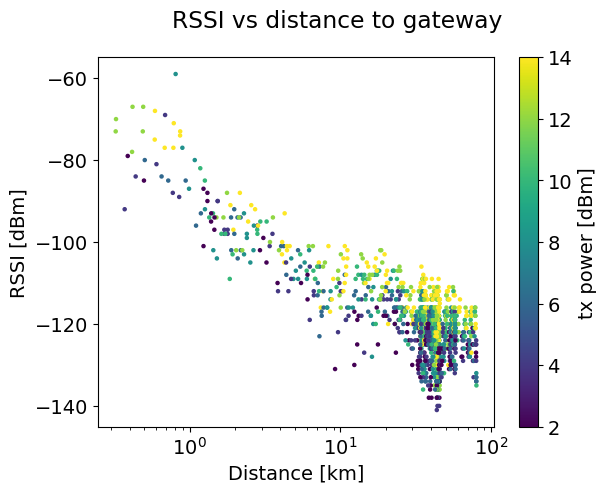

In [18]:


gatewayPoint = [43.706172, -0.251466 , 15]

g = Geod('+ellps=WGS84')

dataPoints = [[packet["estimated_lat_lon_alt"],packet["balloon_id"],packet["tx_power_dbm"],packet["rssi_dbm"]] for packet in data]

# Compute the distance for every data point
distance = []
rssis = []
txs = []
for dataPoint in dataPoints:
    tx = dataPoint[2]
    
    position = dataPoint[0]
    azimuth1, azimuth2, distance2d = g.inv(position[0],position[1],gatewayPoint[0],gatewayPoint[1])
    distance3d = np.hypot(distance2d,gatewayPoint[2] - position[2]) # A recalculer mieux avec la bonne formule
    rssi = dataPoint[3]
    distance.append(distance3d/1000)
    rssis.append(rssi)
    txs.append(tx)


fig,ax = plt.subplots()
fig.suptitle("RSSI vs distance to gateway")
ax.set_xlabel("Distance [km]")
ax.set_xscale('log')
ax.set_ylabel("RSSI [dBm]")
scatter = ax.scatter(distance,rssis,c=txs, s= 5)
cbar = fig.colorbar(scatter)
cbar.set_label("tx power [dBm]")
plt.show()




A more fitting figure would be the attenuation. Witch we will plot next.

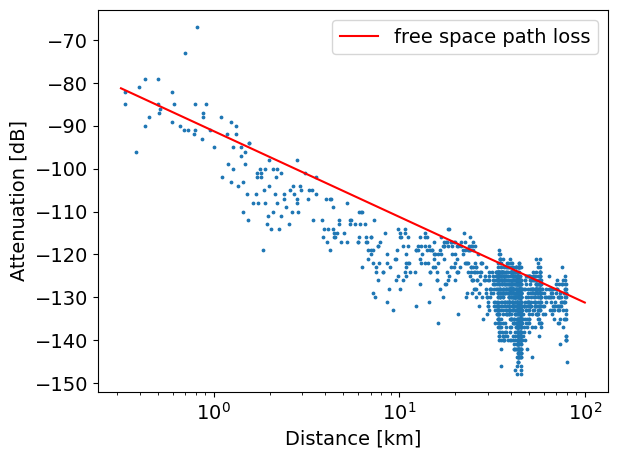

In [19]:

gatewayPoint = [43.706172, -0.251466 , 5]

g = Geod('+ellps=WGS84')

dataPoints = [[packet["estimated_lat_lon_alt"],packet["balloon_id"],packet["tx_power_dbm"],packet["rssi_dbm"],packet["rx_timestamp_ms"]] for packet in data]

# Compute the distance for every data point
distance = []
rssis = []
txs = []
rx_timestamps = []
for dataPoint in dataPoints:
    position = dataPoint[0]

    tx = dataPoint[2]

    azimuth1, azimuth2, distance2d = g.inv(position[0],position[1],gatewayPoint[0],gatewayPoint[1])
    distance3d = np.hypot(distance2d,gatewayPoint[2] - position[2])

    # Filter out the packets that are at less than 100 meters of the gateway
    if distance3d <= 100:
        continue

    rssi = dataPoint[3]
    time = dataPoint[4]

    distance.append(distance3d/1000)
    rssis.append(rssi)
    txs.append(tx)
    rx_timestamps.append(time)


attenuation = [ rssis[i] - tx for i,tx in enumerate(txs) ]


fig,ax = plt.subplots()
ax.set_xlabel("Distance [km]")
ax.set_xscale('log')
ax.set_ylabel("Attenuation [dB]")
scatter = ax.scatter(distance,attenuation,s=3)

# add the free space path loss

distances = np.logspace(-.5,2,1000)
lightspeed = 299792.458 #km/s
frequency = 868000000 #Hz
wavelength = lightspeed / frequency
fspl = 10*np.log10((wavelength/(4*np.pi * distances))**2)


ax.plot(distances,fspl,color="red",label="free space path loss")
ax.legend()
plt.tight_layout()

os.makedirs("../dataset/output",exist_ok=True)
plt.savefig("../dataset/output/atenuation_vs_distance_to_gateway.pdf",transparent=True,dpi=200)
plt.show()



We want to check that the higher TX have succesfully sent more packets that the others

- Filter the packets out of flight time
- Use the frame counter to figure out wich TX should have been used

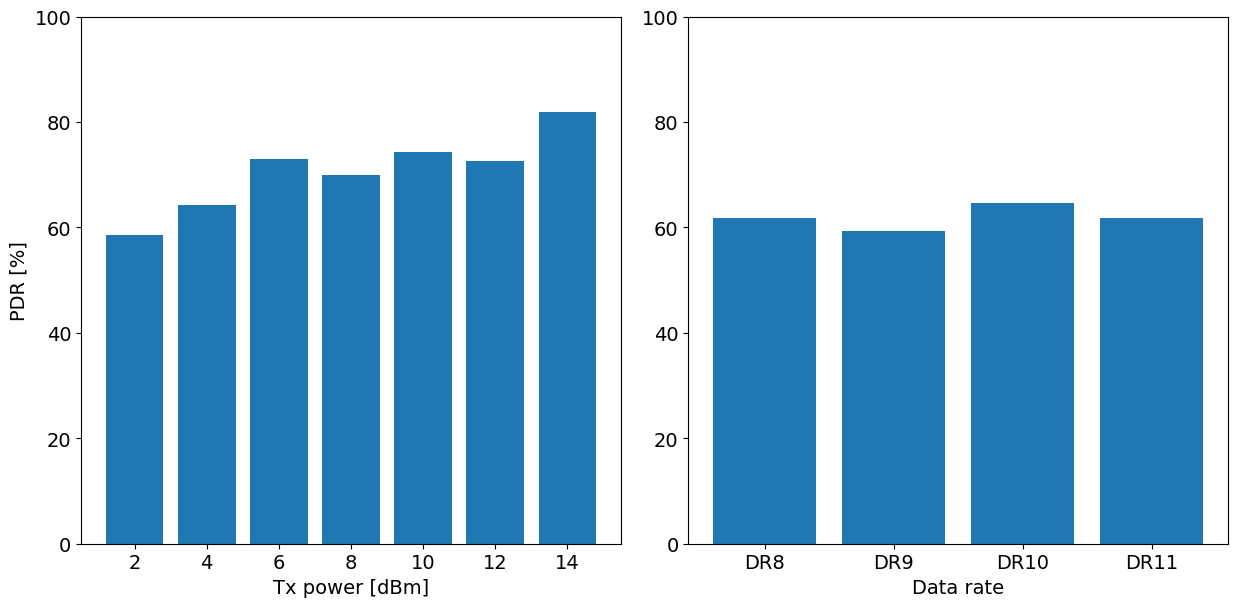

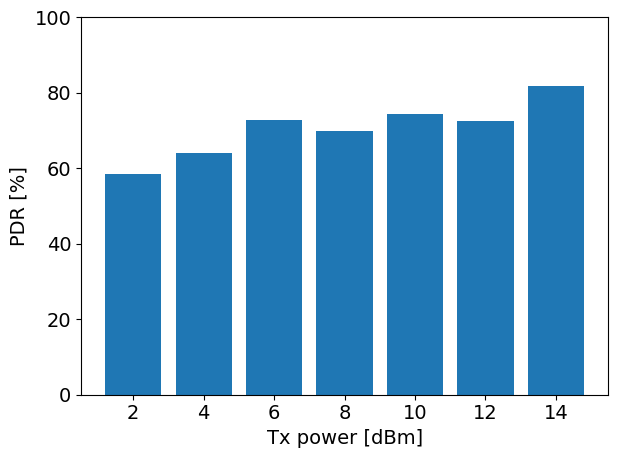

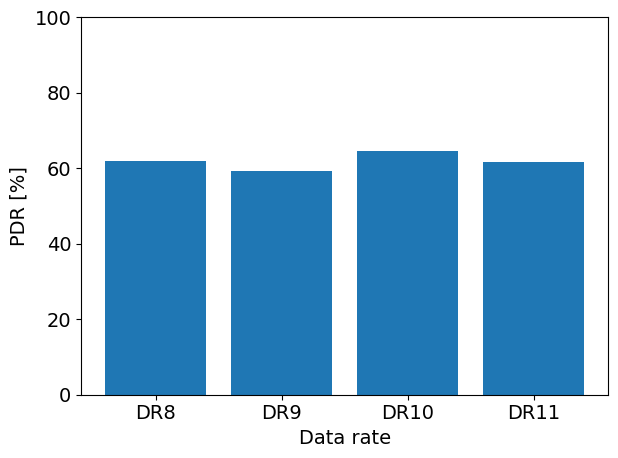

In [20]:
# Helper function to get the Tx and Data Rate from the frame counter. They work because the end device only send unconfirmend data up frames. There are no join or other frames that could mess up the frame counter. 
 
def getTx(fCnt):
    return (((fCnt//4) % 8) + 1)*2

def getDR(fCnt):
    return f"DR{8 + fCnt%4}"


dataPoints = [[packet["rx_timestamp_ms"],packet["estimated_lat_lon_alt"][2],packet["balloon_id"],packet["dev_addr"],packet["frame_counter"],packet["tx_power_dbm"]] for packet in data]

# We want to Plot the succes rate of all of the tx powers and all of the DR

# First we filter the data by device, because they all have != tx_power

successfull_transmissions = {}

for dataPoint in dataPoints:
    dev_addr = dataPoint[3]
    successfull_transmissions.setdefault(dev_addr,[])
    # if the altitude is less than 0, filter it out
    altitude = dataPoint[1]
    if altitude <= 0: 
        continue
    # Else store: frameCounter
    successfull_transmissions[dev_addr].append(dataPoint[4])

failed_transmissions = {}

for dev_addr in successfull_transmissions:
    firstFCnt = successfull_transmissions[dev_addr][0]
    lastFCnt =  successfull_transmissions[dev_addr][-1]

    allFCnt = list(range(firstFCnt,lastFCnt+1))

    device_failed_transmissions = [fCnt for fCnt in allFCnt if fCnt not in successfull_transmissions[dev_addr]]
    failed_transmissions[dev_addr] = device_failed_transmissions


# Count the fail TX and DR for each dataRate and TX
successfull_tx = {}
successfull_dr = {}
for dev_addr in successfull_transmissions:
    for fCnt in successfull_transmissions[dev_addr]:
        successfull_tx.setdefault(str(getTx(fCnt)),0)
        successfull_tx[str(getTx(fCnt))] += 1
        successfull_dr.setdefault(getDR(fCnt),0)
        successfull_dr[getDR(fCnt)] += 1

failed_tx = {}
failed_dr = {}
for dev_addr in failed_transmissions:
    for fCnt in failed_transmissions[dev_addr]:
        failed_tx.setdefault(str(getTx(fCnt)),0)
        failed_tx[str(getTx(fCnt))] += 1
        failed_dr.setdefault(getDR(fCnt),0)
        failed_dr[getDR(fCnt)] += 1
# Sort everything
def drSort(dr):
    return int(''.join(filter(str.isdigit,dr[0])))
def txSort(tx):
    return int(tx[0])

successfull_tx = dict(sorted(successfull_tx.items(),key=txSort))
failed_tx = dict(sorted(failed_tx.items(),key=txSort))

successfull_dr = dict(sorted(successfull_dr.items(),key=drSort))
failed_dr = dict(sorted(failed_dr.items(),key=drSort))


# Glob everything together with a percent of succes

percent_succes_tx_list = [[tx,(n_ok/(n_ok + failed_tx[tx])) * 100] for tx,n_ok in successfull_tx.items()]
percent_succes_dr_list = [[dr,(n_ok/(n_ok + failed_dr[dr])) * 100] for dr,n_ok in successfull_dr.items()]

dr,percent_dr = np.transpose(percent_succes_dr_list)
tx,percent_tx = np.transpose(percent_succes_tx_list)
percent_dr = [float(percent) for percent in percent_dr]
percent_tx = [float(percent) for percent in percent_tx]

# Plot the figure
fig,(ax0,ax1) = plt.subplots(1,2)
# fig.suptitle("Successfull transmissions during flights")
ax0.bar(tx,percent_tx)
ax0.set_ylim([0,100])
ax1.bar(dr,percent_dr)
ax1.set_ylim([0,100])
ax0.set_ylabel("PDR [%]")
ax0.set_xlabel("Tx power [dBm]")
ax1.set_xlabel("Data rate")

scale = 0.7
fig.set_size_inches((18*scale,9*scale))

plt.tight_layout()

os.makedirs("../dataset/output",exist_ok=True)
plt.savefig("../dataset/output/packet_delivery_ratio.pdf",transparent=True,dpi=600,format="pdf")


# Plot the figure
fig,(ax0) = plt.subplots()
ax0.bar(tx,percent_tx)
ax0.set_ylim([0,100])
ax0.set_ylabel("PDR [%]")
ax0.set_xlabel("Tx power [dBm]")


plt.tight_layout()
plt.savefig("../dataset/output/pdr_tx.pdf",transparent=True,dpi=600,format="pdf")

# Plot the figure
fig,ax1 = plt.subplots()
ax1.bar(dr,percent_dr)
ax1.set_ylim([0,100])
ax1.set_ylabel("PDR [%]")
ax1.set_xlabel("Data rate")

# print(dr)
# print(percent_dr)


plt.tight_layout()
plt.savefig("../dataset/output/pdr_dr.pdf",transparent=True,dpi=600,format="pdf")



Plot distance of the baloon over time, for evey NCU

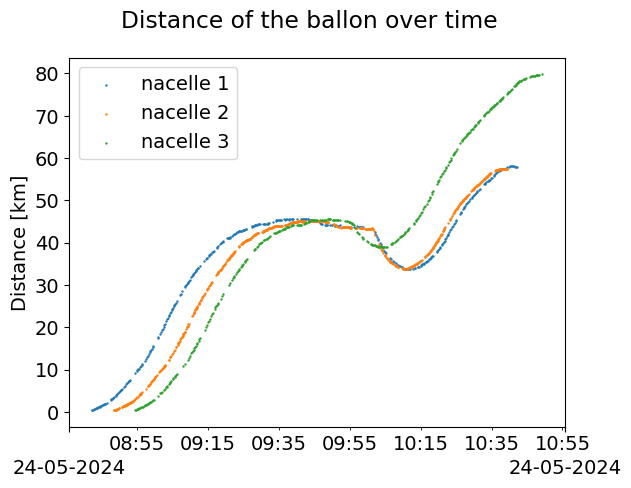

In [21]:


df = pd.read_json("../dataset/dataset_filtered.json")

# Calcul de la distance avec la gateway

def calcul_distance(position):
    _, _, distance2d = g.inv(position[0],position[1],gatewayPoint[0],gatewayPoint[1])
    distance3d = np.hypot(distance2d,gatewayPoint[2] - position[2]) 
    return distance3d/1000 # km

df["distance_km"] = df["estimated_lat_lon_alt"].apply(calcul_distance)

fig,ax = plt.subplots()
fig.suptitle("Distance of the ballon over time")

ax.xaxis.set_minor_locator(dates.MinuteLocator(interval=20))   # every 20 minutes
ax.xaxis.set_minor_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
ax.xaxis.set_major_locator(dates.DayLocator(interval=1))    # every day
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%d-%m-%Y'))

ax.set_ylabel("Distance [km]")
format = EngFormatter(unit="km")
ax.yaxis.set_minor_formatter(format)


for nacelle_number in sorted(df["balloon_id"].unique()):
    # Prendre uniquement la nacelle conçernée
    df_ncu = df[df["balloon_id"] == nacelle_number]
    # Recuperer les timestamps et les distances
    timestamps = df_ncu["rx_timestamp_ms"].to_list()
    timestamps = [datetime.datetime.fromtimestamp(time/1000,datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo) for time in timestamps]
    
    distances = df_ncu["distance_km"].to_list()

    # Plot the valuee
    ax.scatter(timestamps,distances,label=f"nacelle {nacelle_number}",s=0.5)

ax.legend()
plt.show()


    
    

Table displaying the number of frames received for every tx, for every data rate


In [22]:
# Count the number of pairs tx_power / data rate

df = pd.read_json("../dataset/dataset_filtered.json")

df = df[["data_rate","tx_power_dbm"]]
df = df[df["tx_power_dbm"]<= 14]

df = df.groupby(['data_rate', 'tx_power_dbm']).size().to_frame(name='count').reset_index()

# Pivot the DataFrame
pivoted_df = df.pivot_table(index='data_rate', columns='tx_power_dbm', values='count', fill_value=0).astype(int)

# Sort by data_rate in the desired order
data_rate_order = ['DR8', 'DR9', 'DR10', 'DR11']
pivoted_df = pivoted_df.loc[data_rate_order]


# Add a column for row sums
pivoted_df['Row Total'] = pivoted_df.sum(axis=1)

# Add a row for column sums
pivoted_df.loc['Column Total'] = pivoted_df.sum(axis=0)



# Convert to LaTeX with customization, including vertical centering
latex_table = pivoted_df.to_latex(
    caption="Distribution of Data Rates and TX Power",
    label="tab:data_rate_tx_power",
    column_format="l|cccccc|r",  # Adjust column format as needed
    index_names=["Data Rate"],
    multicolumn=True,
    escape=False  # Prevent LaTeX escaping of special characters
)

# Add \centering command to each cell in the 'tx_power_dbm' column
latex_table = latex_table.replace(r" & (\d+) &", r" & \centering $\1$ &")

print(latex_table)

\begin{table}
\caption{Distribution of Data Rates and TX Power}
\label{tab:data_rate_tx_power}
\begin{tabular}{l|cccccc|r}
\toprule
tx_power_dbm & 2 & 4 & 6 & 8 & 10 & 12 & 14 & Row Total \\
data_rate &  &  &  &  &  &  &  &  \\
\midrule
DR8 & 36 & 50 & 48 & 50 & 54 & 50 & 56 & 344 \\
DR9 & 43 & 33 & 48 & 53 & 47 & 48 & 58 & 330 \\
DR10 & 43 & 49 & 61 & 49 & 48 & 53 & 57 & 360 \\
DR11 & 41 & 49 & 50 & 46 & 54 & 48 & 55 & 343 \\
Column Total & 163 & 181 & 207 & 198 & 203 & 199 & 226 & 1377 \\
\bottomrule
\end{tabular}
\end{table}

